In [1]:
import os
import subprocess
import sys
import numpy as np
import itertools
from tqdm import tqdm
from IPython.display import display, HTML
top_level_dir = '/'.join( os.getcwd().split( '/' )[ :-2 ] )
if top_level_dir not in sys.path:
    sys.path.append( top_level_dir )

In [2]:
from GenModels.GM.States.GraphicalMessagePassing import DataGraph, \
                                                        GraphCategoricalForwardBackwardFBS
from GenModels.GM.Distributions import Categorical, Dirichlet, TensorTransition, TensorTransitionDirichletPrior

### Gibbs sampling with graphical hidden markov models can be done with forward sampling the graph:

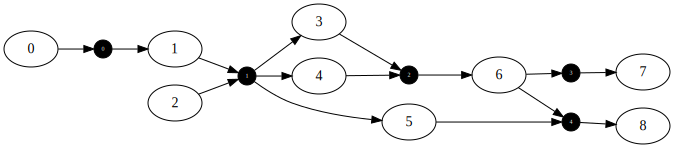

In [3]:
# Latent state size of 3 so that we can use rgb values to interpret them
d_latent = 3
d_obs    = 2

# This is the number of times we measure an emission from the same 
# latent state for a node
measurements = 3

graph = DataGraph()
graph.addEdge( parents=[ 0 ], children=[ 1 ] )
graph.addEdge( parents=[ 1, 2 ], children=[ 3, 4, 5 ] )
graph.addEdge( parents=[ 3, 4 ], children=[ 6 ] )
graph.addEdge( parents=[ 6 ], children=[ 7 ] )
graph.addEdge( parents=[ 5, 6 ], children=[ 8 ] )

# Add random data that is either 0 or 1
for node in graph.nodes:
    data = Categorical.generate( D=d_obs, size=measurements )
    graph.updateNodeData( node, data )

feedback_set = np.array( [ 3, 5 ] )
graph.draw( horizontal=True )

In [4]:
class GrahpState():
    
    def __init__( self, msg, U, V ):
        self.msg = msg
        self.node_states = {}
        self.U = U
        self.V = V
        
    def __call__( self, node_list ):
        # Compute P( x_c | x_p1..pN, Y )
        vals = self.msg.conditionalParentChild( self.U, self.V, node_list )
        
        for node, probs in vals:
            parents, parent_order = msg.getParents( node, get_order=True )
            if( len( parents ) == 0 ):
                prob = probs
            else:
                indices = [ [ self.node_states[ o ] ] for o in parent_order ]
                prob = probs[ indices ].ravel()
            
            # Sample from P( x_c | x_p1..pN, Y )
            state = Categorical.sample( nat_params=( prob, ) )[ 0 ]
            self.node_states[ node ] = state
            

In [5]:
# Initial dist
initial_dist = Categorical( hypers=dict( alpha=np.ones( d_latent ) ) )
initial_sample = initial_dist.pi

# Check how many transition distributions we need
all_transition_counts = set()
for parents in graph.edge_parents:
    ndim = len( parents ) + 1
    all_transition_counts.add( ndim )

# Create the transition distribution
transition_dists = {}
transition_samples = []
for ndim in all_transition_counts:
    dist = TensorTransition( hypers=dict( alpha=np.ones( [ d_latent for _ in range( ndim ) ] ) ) )
    transition_dists[ ndim ] = dist
    transition_samples.append( dist.pi )

# Emission dist
emission_dist = TensorTransition( hypers=dict( alpha=np.ones( ( d_latent, d_obs ) ) ) )
emission_sample = emission_dist.pi

# Create the message passer and initialize
msg = GraphCategoricalForwardBackwardFBS()
msg.updateParams( initial_sample, transition_samples, emission_sample, data_graphs=[ ( graph, feedback_set ) ] )

In [6]:
# Sample X ~ P( X | Y )
def stateResample( msg, initial_dist, transition_dists, emission_dist ):
    msg.updateParams( initial_dist.pi, [ trans.pi for trans in transition_dists.values() ], emission_dist.pi )
    U, V = msg.filter()
    graph_state = GrahpState( msg, U, V )
    marginal = msg.marginalProb( U, V, 0 )
    msg.forwardPass( graph_state )
    return graph_state, marginal

In [7]:
# Sample pi0 ~ P( pi0 | alpha_0, X )
def initialDistResample( msg, graph_state, initial_dist ):
    root_states = np.array( [ state for node, state in graph_state.node_states.items() if msg.nParents( node ) == 0 ] )
    initial_dist.resample( x=root_states )

In [8]:
class TransitionBins():
    def __init__( self, msg, graph_state, ndims ):
        self.msg = msg
        self.graph_state = graph_state
        self.counts = dict( [ ( ndim, [ [] for _ in range( ndim ) ] ) for ndim in ndims ] )
    
    def __call__( self, node_list ):
        for node in filter( lambda n: self.msg.nParents( n ) > 0, node_list ):
            parents, order = self.msg.getParents( node, get_order=True )
            ndim = parents.shape[ 0 ] + 1
            for i, p in zip( order, parents ):
                self.counts[ ndim ][ i ].append( self.graph_state.node_states[ p ] )
            self.counts[ ndim ][ -1 ].append( self.graph_state.node_states[ node ] )
            
# Sample pi ~ P( pi | alpha_pi, X )
def transitionResample( msg, graph_state, transition_dists ):
    transition_bins = TransitionBins( msg, graph_state, transition_dists.keys() )
    msg.forwardPass( transition_bins )
    for ndim in list( transition_dists.keys() ):
        x = [ np.array( count ) for count in transition_bins.counts[ ndim ] ]
        transition_dists[ ndim ].resample( x )

In [9]:
# Sample L ~ P( L | alpha_L, X, Y )
def emissionResample( msg, graph_state, emission_dist ):
    states = []
    emissions = []
    for node in msg.nodes:
        state = graph_state.node_states[ node ]
        state_addition = state * np.ones_like( msg.ys[ node ] )
        states.extend( state_addition.tolist() )
        emissions.extend( msg.ys[ node ].tolist() )
    x = [ np.array( states ), np.array( emissions ) ]
    emission_dist.resample( x )

In [ ]:
for _ in range( 100 ):
    graph_state, marginal = stateResample( msg, initial_dist, transition_dists, emission_dist )
    initialDistResample( msg, graph_state, initial_dist )
    transitionResample( msg, graph_state, transition_dists )
    emissionResample( msg, graph_state, emission_dist )